# Hypothesis Test - does joint sparsity bring any benefit?
In this notebook we examine weather joint sparsity has any benefit over standard sparse coding techniques for classification. The rough idea is that a joint sparse forward pass will learn a code or representation for the a data point that takes into account other examples of the same class. In effect then we are trying to map all members of a given class onto a particular subspace. To test the benefits we consider two tests:
- classification: we perform classification by taking the set of sparse representations of a class and then perform SVD, so as to identify say the top 5 singular vectors that span a linear space that in some sense represents the given class label in the encoder space. We benchmark against standard IHT and PCA.
- reconstruction / decoding: we observe the reconstruction rate for JIHT vs IHT and PCA. It is expected that IHT should have a better reconstruction error.


## Methodology
### For classification:
For the IHT/ JIHT:
- we train a model on MNIST with an IHT/ JIHT forward pass
- we then run the entire MNIST traing set through the modelto find all the training data point encodings
- group the encodings by class, and carry out SVD to find the j singular vectors. These j linear vectors define a linear manifold or subspace which we 'associate' with the class
- then run the entire test set through the model to find all the test data point encodings
- classify each test data point by assigning into the class whose linear manifold or subspace is closest to the data points encoding by projecting

PCA benchmarking approach:
- Find the j principal components of the training data set for each class
- Project the test data onto each of the sets of j principal components of each class
- Assign a test data point to the class for which it has the largest projection (shortest distance) 

Then compare them all by looking at the percentage of data points that they correctly categorised.

### For reconstruction:
For the IHT/ JIHT:
- Simple: forward pass and then reverse pass, calculate l2 distance between decoded and original data point. Calculate the percentage error over the entire test set and training set. Also plot to inpect visually

PCA benchmarking approach:
- Calculate the m principal components of the training data set (these act as our atoms)
- For each data point encode it as the sum of the K principal components that the data point is closest (calculate the inner product between the data point and each principal component, select largest K
- reconstruct data point or image from just these K principal components

Compare the total reconstruction error betweenIHT, JIHT and PCA for both the test and training data sets.

# Import MNIST Data
First script simply imports the MNIST training and test data

In [47]:
import numpy as np
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA 

import random
import os
import yaml
import importlib

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parameters
rep_batch_size = 60000
test_batch_size = 10000

# Set the dimension of the linear manifolds for each class
L=10

# Sparsity value for pca
numb_atoms = 500
K=50



# Load MNIST
root = './data'
download = True  # download MNIST dataset or not

# Access MNIST dataset and define processing transforms to proces
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# trans = transforms.Compose([transforms.ToTensor()])
train_data = dsets.MNIST(root=root, train=True, transform=trans, download=download)
test_data = dsets.MNIST(root=root, train=False, transform=trans)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_data,
                 batch_size=rep_batch_size,
                 sampler = None,
                 shuffle=True)


test_loader = torch.utils.data.DataLoader(
                dataset=test_data,
                batch_size=test_batch_size,
                shuffle=True)

Prepare training and test data to be used in models and hypothesis tests.

In [48]:
# Format data so that can be run through model
train_x, train_labels = next(iter(train_loader))
b_train_x = (train_x.view(-1, 28*28)).to(device)   # batch x, shape (batch, 28*28)
b_train_x_2 = (train_x.view(-1, 28*28)).to(device)   # batch y, shape (batch, 28*28)
b_train_labels = (train_labels).to(device)

test_x, test_labels = next(iter(test_loader))
b_test_x = (test_x.view(-1, 28*28)).to(device)   # batch x, shape (batch, 28*28)
b_test_x_2 = (test_x.view(-1, 28*28)).to(device)   # batch y, shape (batch, 28*28)
b_test_labels = (test_labels).to(device)

# Sort data into classes so that can be processed for classification test
label_bin_data = {"0":[], "1":[], "2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[]}
data_by_class = {}

# Firstly sort data into different classes, where each dictionary member is a list of data points
for i in range(b_train_labels.size()[0]):
    label_bin_data[str(int(b_train_labels[i].item()))].append(b_train_x[i,:])

# Format dictionary so each dictionary element is a matrix of data points
for key, tensor_list in label_bin_data.items():
    if len(label_bin_data[key]) > 0:
        data_by_class[key] = torch.stack(label_bin_data[key], dim=0)
        


# IHT Model

## Reconstruction

Firstly just load the IHT model and check few examples for visual inspection:

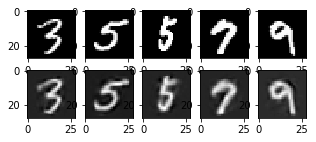

In [49]:
# Load mode
import auxillary as aux
importlib.reload(aux)

N_TEST_IMG = 5

iht_model_id = '570864'
iht_model_filename = 'IHT' + iht_model_id

iht_model = aux.load_model(iht_model_filename)

# Check that reconstructions etc. are working as they
fig = plt.figure(figsize=(5, 2))
# original data (first row) for viewing
# view_data = Variable(test_data.test_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = Variable(b_test_x.view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = view_data.to(device)
decoded, encoded, errIHT = iht_model(view_data)

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+1)
    plt.imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+6)
    plt.imshow(np.reshape(decoded.cpu().data.numpy()[i], (28, 28)), cmap='gray')
    
plt.show()

Calculate overall train and test reconstruction error:

In [51]:
# Process entire data set for the reconstruction test
train_decoding, train_encoding, errIHT_train = iht_model(b_train_x)
test_decoding, test_encoding, errIHT_test = iht_model(b_test_x)

print('Train error: ', errIHT_train[-1])
print('Test error: ', errIHT_test[-1])

Train error:  0.282882660627
Test error:  0.283301621675


## Classification 

We are trying to calculate the low dimensional manifold that best represents each class in the encoded space space. To do this we calculate a set of encodings for each class, and then carry out SVD on this class to find a low dimensional linear manifold which each member of that class at least roughly lies on.

In [52]:
from numpy import linalg as LA
from sklearn.decomposition import PCA

# Initialise the dictionaries to hold the encodings and span of the linear manifolds for each class
iht_class_codes = {}
iht_class_svd = {}

# Process each class set of data points and calculate linear manifold
for key, tensor_list in data_by_class.items():
    if len(data_by_class[key]) > 0:       
        _, iht_class_codes[key], _ = iht_model(data_by_class[key])        
        temp_npy = np.asarray(iht_class_codes[key])
        U, S, Vh = LA.svd(temp_npy.transpose(), full_matrices=True, compute_uv=True)        
        iht_class_svd[key] = U[:,:L]
#         print(data_by_class[key].shape)
#         print(iht_class_codes[key].shape)
#         print(U.shape)
#         print(iht_class_svd[key].shape)

With the linear manifold calculated for each class test by processing the test data set and classifying each test data point by projecting onto each class linear manifold, and assign it a label by choosing the class for which it has the smallest projection (is closest to).

In [54]:
# Initialise matrix to store the projections of each data point onto each class
x_test_proj = np.zeros((test_batch_size, 10))

# Create sparse code for each test data point
_, iht_test_codes,_ = iht_model(b_test_x)
print(iht_test_codes.shape)

for key, tensor_list in iht_class_svd.items():
    if len(iht_class_svd[key]) > 0:        
        x_test_proj[:, int(key)] = np.sqrt(np.sum(np.matmul(iht_test_codes, iht_class_svd[key])**2, axis=1))
        
label_estimates_iht = np.argmax(x_test_proj, axis=1)
class_error_rate_iht = 100*(1 - np.sum(np.sum(label_estimates_iht == b_test_labels.data.numpy()))/test_batch_size)

print("IHT classification error rate via the projection method: ", class_error_rate_iht, "%")

torch.Size([10000, 500])
IHT classification error rate via the projection method:  6.82 %


# JIHT Model

## Reconstruction

Firstly just load the JIHT model and check few examples for visual inspection.

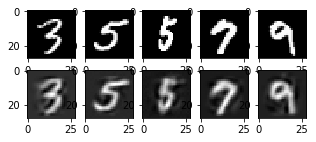

In [55]:
# Load mode
import auxillary as aux
importlib.reload(aux)

N_TEST_IMG = 5

jiht_model_id = '330096'
jiht_model_filename = 'JIHT' + jiht_model_id

jiht_model = aux.load_model(jiht_model_filename)

# Check that reconstructions etc. are working as they
fig = plt.figure(figsize=(5, 2))
# original data (first row) for viewing
# view_data = Variable(test_data.test_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = Variable(b_test_x.view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = view_data.to(device)
decoded, encoded, errIHT = jiht_model.forward(view_data)

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+1)
    plt.imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+6)
    plt.imshow(np.reshape(decoded.cpu().data.numpy()[i], (28, 28)), cmap='gray')
    
plt.show()

Calculate overall train and test reconstruction error:

In [56]:
# Process entire data set for the reconstruction test
train_decoding, train_encoding, errJIHT_train = jiht_model(b_train_x)
test_decoding, test_encoding, errJIHT_test = jiht_model(b_test_x)

print('Train error: ', errJIHT_train[-1])
print('Test error: ', errJIHT_test[-1])

Train error:  0.3552493155
Test error:  0.349918305874


## Classification

We are trying to calculate the low dimensional manifold that best represents each class in the encoded space space. To do this we calculate a set of encodings for each class, and then carry out SVD on this class to find a low dimensional linear manifold which each member of that class at least roughly lies on.

In [57]:
from numpy import linalg as LA
from sklearn.decomposition import PCA

# Initialise the dictionaries to hold the encodings and span of the linear manifolds for each class
jiht_class_codes = {}
jiht_class_svd = {}

# Process each class set of data points and calculate linear manifold
for key, tensor_list in data_by_class.items():
    if len(data_by_class[key]) > 0:       
        _, jiht_class_codes[key], _ = jiht_model.forward(data_by_class[key])        
        temp_npy = np.asarray(jiht_class_codes[key])
        U, S, Vh = LA.svd(temp_npy.transpose(), full_matrices=True, compute_uv=True)        
        jiht_class_svd[key] = U[:,:L]

With the linear manifold calculated for each class test by processing the test data set and classifying each test data point by projecting onto each class linear manifold, and assign it a label by choosing the class for which it has the smallest projection (is closest to).

In [58]:
# Initialise matrix to store the projections of each data point onto each class
x_test_proj = np.zeros((test_batch_size, 10))

# Create sparse code for each test data point
_, jiht_test_codes,_ = jiht_model(b_test_x)

for key, tensor_list in jiht_class_svd.items():
    if len(jiht_class_svd[key]) > 0:
        
        x_test_proj[:, int(key)] = np.sqrt(np.sum(np.matmul(jiht_test_codes, jiht_class_svd[key])**2, axis=1))
        
label_estimates_jiht = np.argmax(x_test_proj, axis=1)
class_error_rate_jiht = 100*(1 - np.sum(np.sum(label_estimates_jiht == b_test_labels.data.numpy()))/test_batch_size)

print("JIHT classification error rate via the projection method: ", class_error_rate_jiht, "%")

JIHT classification error rate via the projection method:  7.09 %


# PCA Model

## Reconstruction

To create a parrallel and fair benchmark with PCA we consider calculating in some sense an equivalent dictionary of linear basis elements as to those we learn with the IHT and JIHT during training. Then we enforce sparsity by projecting each test data point onto each of the principal components, and reconstruct by combining the largest 25 using the inner product as the coefficient.

In [59]:
# Calculate PCA 'dictionary'
pca = PCA(n_components=numb_atoms)
pca.fit_transform(b_train_x)
princ_components = pca.components_
print(princ_components.shape)

(500, 784)


Now that we have the 'dictionary' of vectors (principal components we calculate the inner product between each of the test data points and the atoms of the PCA dictionary. We reconstruct by doing the combining the K principal components in a linear combination with their respective inner products with the data point acting as coefficients. Might be better in some sense to find the coefficients by solving a linear system for each coefficient? This would either mean solving the thin matrix system for each data point or doing soem sort of sparse coding setup.

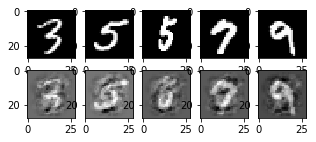

In [60]:
N_TEST_IMG = 5

train_inner_products = np.matmul(princ_components, np.transpose(b_train_x.data.cpu().numpy()))
order = np.sort(np.abs(train_inner_products), axis=0)
Kth_largest_elements = order[K,:]
mask = train_inner_products>Kth_largest_elements
train_decoded = np.transpose(np.matmul(np.transpose(princ_components), mask*train_inner_products))

test_inner_products = np.matmul(princ_components, np.transpose(b_test_x.data.cpu().numpy()))
order = np.sort(np.abs(test_inner_products), axis=0)
Kth_largest_elements = order[K,:]
mask = test_inner_products>Kth_largest_elements
test_decoded = np.transpose(np.matmul(np.transpose(princ_components), mask*test_inner_products))

# Check that reconstructions etc. are working as they
fig = plt.figure(figsize=(5, 2))
# original data (first row) for viewing
# view_data = Variable(test_data.test_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = Variable(b_test_x.view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = view_data.to(device)

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+1)
    plt.imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+6)
    plt.imshow(np.reshape(test_decoded[i], (28, 28)), cmap='gray')
    
plt.show()

The reconstruction error across the test set is as follows.

In [61]:
pca_train_error = np.linalg.norm(np.asarray(b_train_x_2) - train_decoded,'fro') / np.linalg.norm(np.asarray(b_train_x_2),'fro')
pca_test_error = np.linalg.norm(np.asarray(b_test_x_2) - test_decoded,'fro') / np.linalg.norm(np.asarray(b_test_x_2),'fro')
print('Train error: ', pca_train_error)
print('Test error: ', pca_test_error)

Train error:  0.651945822762
Test error:  0.64789532079


## Classification

To make a fair benchmark for classification we once again use the sorted training data to create linear manifolds based of the largest L PCA components.

In [62]:
pca_class = {}

for key, tensor_list in data_by_class.items():
    if len(data_by_class[key]) > 0:               
        temp_npy = np.asarray(data_by_class[key])
        pca = PCA(n_components=L)
        pca.fit_transform(temp_npy)
        pca_class[key] = np.transpose(pca.components_)

Now we perform analagous steps as before, however instead of projecting into some encoding space and our linear manifolds are in the image space in the case of PCA. We simply project each image onto each class linear manifold and assign it the label of the class that is closest.

In [63]:
# Initialise matrix to store the projections of each data point onto each class
x_test_proj = np.zeros((test_batch_size, 10))

for key, tensor_list in pca_class.items():
    if len(pca_class[key]) > 0:       
        x_test_proj[:, int(key)] = np.sqrt(np.sum(np.matmul(b_test_x, pca_class[key])**2, axis=1))
        
label_estimates_pca = np.argmax(x_test_proj, axis=1)
class_error_rate_pca = 100*(1 - np.sum(np.sum(label_estimates_pca == b_test_labels.data.numpy()))/test_batch_size)

print("PCA classification error rate via the projection method: ", class_error_rate_pca, "%")

PCA classification error rate via the projection method:  7.6 %
